<a href="https://colab.research.google.com/github/aarakova/AD/blob/VVSiT/%D0%92%D0%A1%D0%A1%D0%B8%D0%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

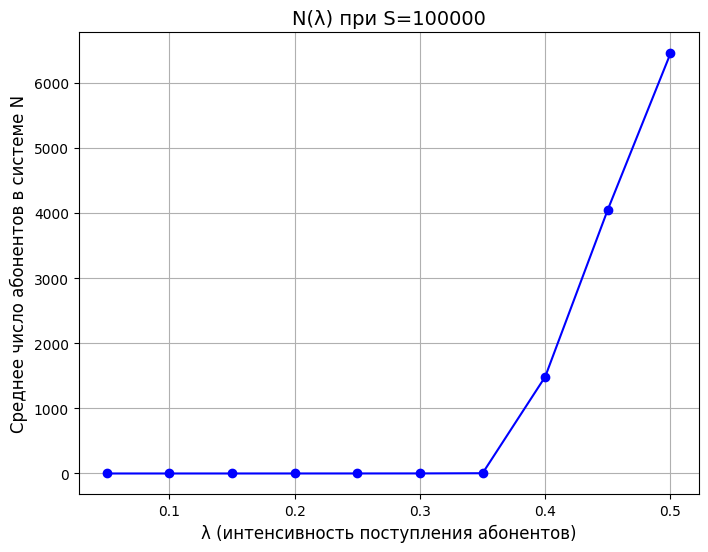

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры модели
lambda_values = np.arange(0.05, 0.55, 0.05)  # Значения λ от 0.05 до 0.5 с шагом 0.05
S = 100000  # Конкретное значение S для построения графика


# Функция моделирования
  def simulate_system(lambda_value, S):
      N_total = 0  # Суммарное количество абонентов за все слоты
      G_total = 0  # Суммарная пропускная способность
      N_i = 0  # Текущее количество абонентов в системе

      for i in range(S):
          # Новые абоненты по распределению Пуассона
          P_i = np.random.poisson(lambda_value)

          # Количество передающих абонентов в текущем слоте по биномиальному распределению
          R_i = np.random.binomial(N_i, 1 / N_i) if N_i > 0 else 0

          # Определение события
          if R_i == 1:  # Успех
              N_i -= 1  # Абонент уходит из системы
              G_total += 1  # Пропускная способность увеличивается
          elif R_i > 1:  # Конфликт
              pass  # Абоненты остаются в системе для следующей попытки
          # Если R_i == 0 - пустой слот

          # Обновляем общее количество абонентов
          N_i += P_i
          N_total += N_i

      # Среднее количество абонентов в системе
      N_avg = N_total / S
      return N_avg


# Запуск симуляции для значений λ
N_averages = [simulate_system(lambda_value, S) for lambda_value in lambda_values]

# Построение графика N(λ)
plt.figure(figsize=(8, 6))  # Задаем размер графика
plt.plot(lambda_values, N_averages, marker='o', color='blue')

# Настройка заголовка и осей
plt.title(f"N(λ) при S={S}", fontsize=14)
plt.xlabel("λ (интенсивность поступления абонентов)", fontsize=12)
plt.ylabel("Среднее число абонентов в системе N", fontsize=12)
plt.grid(True)

# Отображение графика
plt.show()


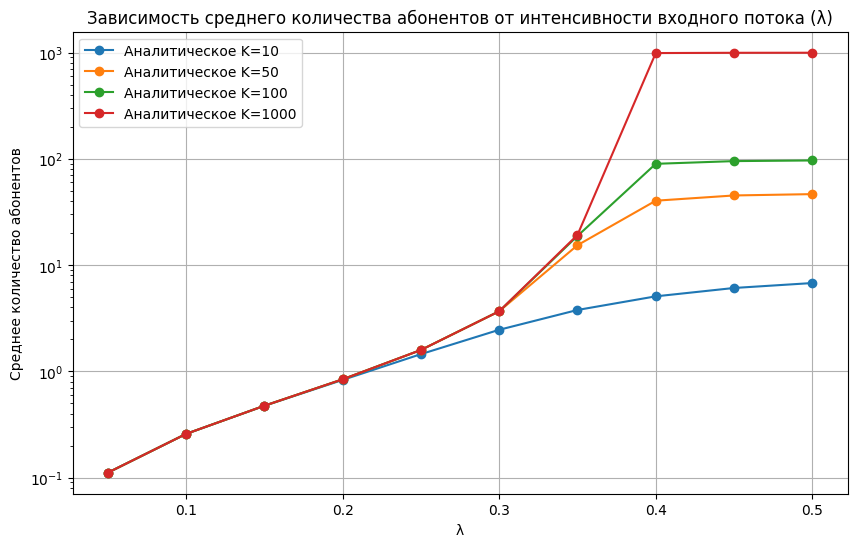

Предсказанное среднее количество абонентов при λ=0.4 и K=50: 40.35


In [ ]:
import numpy as np
from scipy.special import factorial
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Функция для построения матрицы переходов и решения системы
def solve_stationary_distribution(K, lmbda):
    T_matrix = np.zeros((K, K))  # Матрица переходных вероятностей

    # Заполнение матрицы переходов
    for i in range(K):
        for j in range(K):
            if i == 0:
                T_matrix[i, j] = np.exp(-lmbda) * lmbda**j / factorial(j)
            elif j == i - 1:
                T_matrix[i, j] = (1 - 1/i)**j * np.exp(-lmbda)
            elif j == i:
                T_matrix[i, j] = (
                    (1 - (1 - 1/i)**j) * np.exp(-lmbda) +
                    (1 - 1/i)**j * (lmbda * np.exp(-lmbda))
                )
            elif j > i:
                T_matrix[i, j] = (
                    (1 - 1/i)**j * np.exp(-lmbda) * lmbda**(j-i+1) / factorial(j-i+1) +
                    (1 - (1 - 1/i)**j) * np.exp(-lmbda) * lmbda**(j-i) / factorial(j-i)
                )

        # Нормировка строк
        row_sum = T_matrix[i, :].sum()
        T_matrix[i, :] /= row_sum

    # Решение системы уравнений πT = π и условия нормировки
    A = np.transpose(T_matrix) - np.eye(K)
    A[-1, :] = 1
    b = np.zeros(K)
    b[-1] = 1

    pi = solve(A, b)

    # print(f"Матрица переходных вероятностей T для K={K}, λ={lmbda}:\n{T_matrix}")
    # print(f"Вектор стационарного распределения π для K={K}, λ={lmbda}:\n{pi}")

    return pi

# Функция для предсказания среднего количества абонентов
def predict_average_clients(pi):
    return sum(i * pi[i] for i in range(len(pi)))

# Построение графиков
def plot_combined_graphs(K_values, lambda_values, S):
    plt.figure(figsize=(10, 6))

    # Аналитические результаты
    for K in K_values:
        N_values = []
        for lmbda in lambda_values:
            pi = solve_stationary_distribution(K, lmbda)
            N_avg = predict_average_clients(pi)
            N_values.append(N_avg)
        plt.plot(lambda_values, N_values, marker='o', label=f"Аналитическое K={K}")

    plt.xlabel("λ")
    plt.ylabel("Среднее количество абонентов")
    plt.title("Зависимость среднего количества абонентов от интенсивности входного потока (λ)")
    plt.yscale("log")  # Логарифмическая шкала
    plt.grid()
    plt.legend()
    plt.show()

# Параметры
K_values = [10, 50, 100, 1000]  # Множество K для аналитического расчёта
lambda_values = np.arange(0.05, 0.55, 0.05).tolist()  # Значения λ

# Запуск построения графиков
plot_combined_graphs(K_values, lambda_values, S)

# Дополнительный вывод для одного фиксированного λ
fixed_lambda = 0.4
K_fixed = 50
pi_fixed = solve_stationary_distribution(K_fixed, fixed_lambda)
N_fixed = predict_average_clients(pi_fixed)
print(f"Предсказанное среднее количество абонентов при λ={fixed_lambda} и K={K_fixed}: {N_fixed:.2f}")


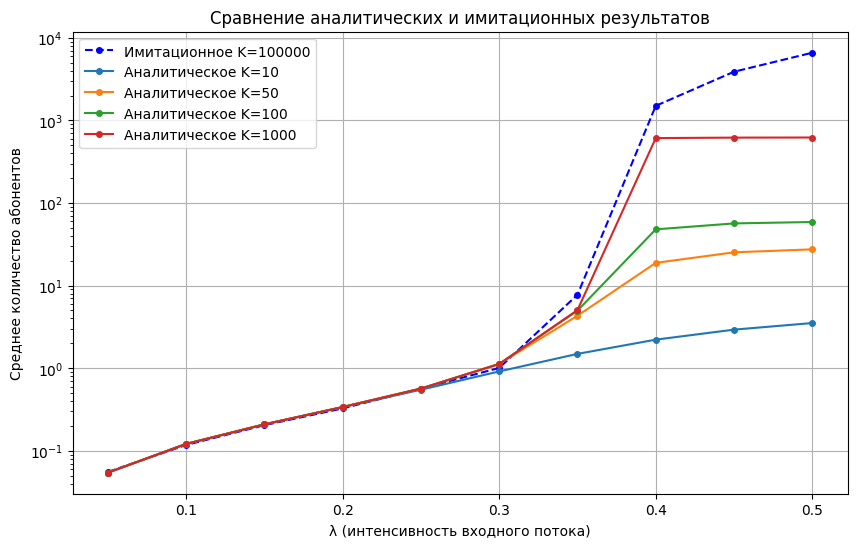

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import factorial
from scipy.linalg import solve

# Функция для построения матрицы переходов
def transition_matrix(k: int, lam):
    P = np.zeros((k + 1, k + 1))  # Матрица размером (k+1) x (k+1)
    Pk = [(lam**n) / factorial(n) * np.exp(-lam) for n in range(k + 1)]  # Пуассоновские вероятности

    for i in range(k + 1):
        Rk_1 = ((1 - 1 / i) ** (i - 1)) if i > 0 else 0  # Вероятность успеха передачи
        for j in range(k + 1):
            if i == 0:  # Переходы из состояния 0 (добавляются новые абоненты)
                P[i, j] = Pk[j]
            elif j == i - 1:  # Успех передачи (i -> i-1)
                P[i, j] = Rk_1 * Pk[0]
            elif j == i:  # Состояние сохраняется
                P[i, j] = (1 - Rk_1) * Pk[0] + Rk_1 * Pk[1]
            elif j > i:  # Переходы с добавлением новых абонентов
                P[i, j] = Rk_1 * Pk[j - i + 1] + (1 - Rk_1) * Pk[j - i]
    return P


# Функция для решения линейных уравнений для нахождения стационарного распределения
def stationary_distribution(P: np.ndarray):
    K = P.shape[0] - 1
    A = np.vstack([P.T - np.eye(K + 1), np.ones(K + 1)])  # Добавляем уравнение нормировки
    b = np.zeros(K + 2)
    b[-1] = 1  # Сумма вероятностей равна 1
    return scipy.linalg.solve(A.T @ A, A.T @ b)


# Построение графиков
def plot_combined_graphs():
    results: dict[int, list] = {K: [] for K in k_values}

    # Аналитические результаты
    for K in k_values:
        for lam in lambdas:
            P = transition_matrix(K, lam)  # Построение матрицы переходов
            pi = stationary_distribution(P)  # Стационарное распределение
            states = np.arange(K + 1)  # Возможные состояния
            M = np.dot(pi, states)  # Среднее количество абонентов
            results[K].append(M)

    # Имитационные результаты с готовой функцией simulate_system
    average_N_values_model = [simulate_system(lam, S) for lam in lambdas]

    # Построение графиков
    plt.figure(figsize=(10, 6))
    plt.yscale("log")

    # Имитационное моделирование
    plt.plot(
        lambdas,
        average_N_values_model,
        marker="o",
        label="Имитационное K=100000",
        color="b",
        linestyle="--",
        markersize=4,
    )

    # Аналитические результаты
    for K, M_values in results.items():
        plt.plot(
            lambdas,
            M_values,
            marker="o",
            label=f"Аналитическое K={K}",
            markersize=4,
        )

    # Оформление графика
    plt.title("Сравнение аналитических и имитационных результатов")
    plt.xlabel("λ (интенсивность входного потока)")
    plt.ylabel("Среднее количество абонентов")
    plt.legend()
    plt.grid()
    plt.show()


# Параметры
lambdas = np.arange(0.05, 0.55, 0.05)  # Значения λ от 0.05 до 0.5
k_values = [10, 50, 100, 1000]  # Множество K
S = 100000  # Количество слотов

if __name__ == "__main__":
    plot_combined_graphs()


In [80]:
transition_matrix(k=6, lam=0.15)

array([[8.18730753e-01, 1.63746151e-01, 1.63746151e-02, 1.09164100e-03,
        5.45820502e-05, 2.18328201e-06, 7.27760669e-08, 2.07931620e-09,
        5.19829050e-11, 1.15517567e-12, 2.31035133e-14],
       [8.18730753e-01, 1.63746151e-01, 1.63746151e-02, 1.09164100e-03,
        5.45820502e-05, 2.18328201e-06, 7.27760669e-08, 2.07931620e-09,
        5.19829050e-11, 1.15517567e-12, 2.31035133e-14],
       [0.00000000e+00, 4.09365377e-01, 4.91238452e-01, 9.00603828e-02,
        8.73312803e-03, 5.73111527e-04, 2.83826661e-05, 1.12802904e-06,
        3.74276916e-08, 1.06564955e-09, 2.65690403e-11],
       [0.00000000e+00, 0.00000000e+00, 3.63880335e-01, 5.27626485e-01,
        9.82476904e-02, 9.58218215e-03, 6.30725913e-04, 3.12937088e-05,
        1.24527937e-06, 4.13552888e-08, 1.17827918e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.45402036e-01,
        5.42409124e-01, 1.01573784e-01, 9.92711038e-03, 6.54131758e-04,
        3.24763199e-05, 1.29291231e-06, 4.29508752e-

In [81]:
pi = stationary_distribution(P)
pi

array([6.95312316e-05, 4.44522674e-05, 3.12870558e-05, ...,
       1.02721330e-03, 8.06098109e-04, 4.80233945e-04])